<a name="top">
    Top of page
</a>

## 5B - Hands on Building of a Geographic Model
### Facility Location Problems - Group Exercise

Working in your PSGs, use what you have just observed (and learned) to tackle the following case study. In the cells below there will be omissions (denoted with **\*\***) that need to be completed correctly to move on to the next step.


#### Case Study: TIA Clinics in Cornwall

Transient Ischaemic Attacks (TIAs) are a minor type of stroke (disruption of blood flow to the brain) where symptoms may last for up to 24 hours. TIAs can be important predictors of major strokes. These can can be fatal or cause substantial disability. Therefore, it is important for patients to have suitable and equitable access to a specialist TIA clinic shortly after their symptoms occur.

This case study is set in Cornwall where TIA patients are currently assessed and treated at five clinic locations. Due to funding constraints not all locations are open every day. The locations are:

* Royal Cornwall Hospital Trust (RCHT)
* Cambourne Redruth Community Hospital (CRCH)
* St. Austell Community Hospital (SACH)
* Bodmin Community Hospital (BODMIN)
* West Cornwall Hospital (WCH)

Local NHS commissioners are considering the future of the service. They feel that five clinic locations is leading to variation in the quality of patient treatment and would like to **consolidate to three locations.** 

*They have asked for our help in making and supporting their decision making.*

The data provided comprises of:

* *tia_travel_matrix.csv* - Travel time matrix from different locations
* *tia_attendances.csv* - Number of TIA clinic attendances per LSOA

Similar to the demonstration, you will be following the steps below within this notebook:

[1. Library Imports](#lib_imports)\
[2. Data Imports](#data_imports)\
[3. Representing a Solution](#rep_sol)\
[4. Constructing a Random Solution](#cons_random)\
[5. Evaluating a Solution](#eval_sol)\
[6. Enumerating all Possible Combinations](#small_prob)\
[7. Bruteforce](#bruteforce)\
[8. Graphical Representation](#bar_chart)


**Note** Using line numbers within cells may aid readability. Press `Shift` + `L` to toggle on/ off.

### 1. Library Imports
<a name="lib_imports">
   Code to Import Libraries
</a>

Step 1. Do you remember which *standard* libraries were imported during the demonstration? Import them again to complete the rest of this exercise. **Hint - there are 3**

Because we're nice, we've already provided the two additional libraries.

In [1]:
# update the code below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Additionally, we'll also use....
# combinations from the itertools library allows us to enumerate all 
# solutions (for small instances).
from itertools import combinations

# Metapy package imports
# Required for a Weighted Average Objective
# Ensure you have the 'metapy' folder (and contents) within your 
# current working directory
from metapy.evolutionary.evolutionary import WeightedAverageObjective

### 2. Data Imports
<a name="data_imports">
   Code to Import Data
</a>

Step 2 is to import the travel matrix file named `tia_travel_matrix.csv` and check that the file has been read correctly. This file is saved in the same location as the clinic car travel time, shown in the demonstration. Define the index as `LSOA11CD`

In [2]:
# your code goes here ...
travel_matrix = pd.read_csv('./data/tia_travel_matrix.csv', 
                            index_col='sector')
travel_matrix.head()

,SACH,BODMIN,RCHT,CRCH,WCH
sector,,,,,
E01018750,40,31,60,66,87
E01018751,40,31,60,66,87
E01018752,41,32,61,67,88
E01018753,43,34,64,69,90
E01018754,46,38,67,72,93


Step 3 is to import the number of `tia_attendances.csv` file (in the same location). Again, check it's been read correctly and remember to set the index to `LSOA11CD`.

In [3]:
# your code goes here ...
attends = pd.read_csv('./data/tia_attendances.csv', 
                            index_col='sector')
attends.head()

,n_patients
sector,
E01018757,3
E01018758,10
E01018761,19
E01018763,2
E01018768,6


### 3. Representing a Solution
<a name="rep_sol">
   Code to Represent a Proposed Solution
</a>

From the above you'll have seen that you've been provided with a travel matrix containing 5 clinic locations. For this case study, the 'solution' will comprise of 3 proposed clinics.

Step 4-A is to manually define a solution array with the index numbers of 3 clinics.

In [4]:
# your code goes here ...
solution = np.array([1, 0, 3])

Step 4-B is to declare a mask variable that contains the respective columns from the travel matrix. 

In [5]:
# your code goes here ...
mask = travel_matrix.columns[solution]

Step 4-C display the restrcited columns from the travel matrix, using mask from Step 4-B, above.

In [6]:
# your code goes here ...
travel_matrix[mask]

,BODMIN,SACH,CRCH
sector,,,
E01018750,31,40,66
E01018751,31,40,66
E01018752,32,41,67
E01018753,34,43,69
E01018754,38,46,72
...,...,...,...
E01019076,9,10,38
E01033289,21,30,41
E01033291,18,35,53


### 4. Constructing a Random Solution
<a name="cons_random">
   Code to Represent a Proposed Solution
</a>

Now it's time to generate a random solution. Remember the `random_solution` function from the demonstration? Lets put it to use.

In [7]:
def random_solution(n_candidates, p, random_seed=None):
    '''
    Helper function to generate a random solution
    
    Params
    ------
    n_candidates : int
        The number of candidate locations where you could place 
        clinics (facilities).
        
    p : int
        The number of clinics to place.
        
    random_seed : int (Default=None)
        Random seed for reproducibility.
    
    Returns
    -------
    
    Vector (np.array) of length p
    '''
    # create a random number generator
    rng = np.random.default_rng(seed=random_seed)

    # sample without replacement
    solution = []
    while len(solution) < p:
        candidate = rng.integers(0, n_candidates)
        if candidate not in solution:
            solution.append(candidate)
            
    return np.array(solution)

Step 5 is to generate and store a random initial solution using the function above. Remember to get the parameters for the number of candidates and clinics correct. To ensure reproducibility, set a random seed of 42.

In [8]:
# your code goes here ...
init_solution = random_solution(5, 3, random_seed=42)
init_solution

array([0, 3, 2])

**Question:** In your groups, discuss how the `random_solution` and `random_solution2` functions differ. Does everyone in the group understand? Which is more elegant (and why)?

### 5. Evaluating a Solution
<a name="eval_sol">
   Code to Represent a Proposed Solution
</a>

We've now got everything we need to evaluate the solution using weighted average travel times? The code for the WeightedAverageObjective object has been inserted for you below.

**Note: that index must have the heading of `sector`**

In [9]:
obj = WeightedAverageObjective(attends, travel_matrix)

Step 6 is to evaluate the initial solution from Step 5 using the WeightedAverageObjective (new) variable, declared above.

In [10]:
# your code goes here ...
obj.evaluate(init_solution)

15.133891213389122

### 6. Enumerating all Possible Combinations
<a name="small_prob">
   Code to Enumerate all Possible Facility Combinations.
</a>

The `all_combinations` function has been provided below.

**Question** Who can remember what a list comprehension is? Where is it used in the function, below?

In [11]:
def all_combinations(n_facilities, p):
    '''
    n_facilities : int
        The number of candidate locations where you could place facilities (clinics).
        
    p : int
        The number of clinics to place.
    
    Returns
    -------
    
    Returns all p sized combinations of an array containing
    indicies 0 to n_facilties - 1 
    '''
    facility = np.arange(n_facilities, dtype=np.uint8)
    return [np.array(a) for a in combinations(facility, p)]

Step 7-A is to use the function above to print the total number of possible combinations (remember - we're looking for 3 locations from the existing 5 clinics).

In [12]:
# your code goes here ...
comb = all_combinations(n_facilities=5, p=3)
len(comb)

10

Step 7-B is to take a look at one of the combinations. What combination of clinics is propsed in the 5th element of the array of combinations?

In [13]:
# your code goes here ...
comb[4]

array([0, 2, 4], dtype=uint8)

### 7. Bruteforce
<a name="bruteforce">
   Code to assess all possible clinic combinations with respect ot weighted average travel time.
</a>



Step 8-A is to create a list of the evaluated solutions. Once all evaluations have been added, convert the list to a Numpy array.

In [14]:
# your code goes here ...
results = []
for solution in comb:
    results.append(obj.evaluate(solution))
results = np.array(results)

Step 8-B is to extract and print the index of the optimal solution.

In [15]:
# your code goes here ...
optimal_index = np.argmin(results)
print('The index of the combinations offering the optimal'+\
      f' solution is {optimal_index}')

The index of the combinations offering the optimal solution is 8


### 8. Graphical Representation
<a name="bar_chart">
   Code to generate a bar chart representing to assessment above.
</a>

The final Step, 9, is to generate a bar chart of all possible solution costs.

Your chart should include the following elements:
* All possible clinic combinations represented as bars
* Lowest cost solution should be coloured in **green**
* Title
* x-axis label
* y-axis label


Text(0, 0.5, "Travel 'Cost'")

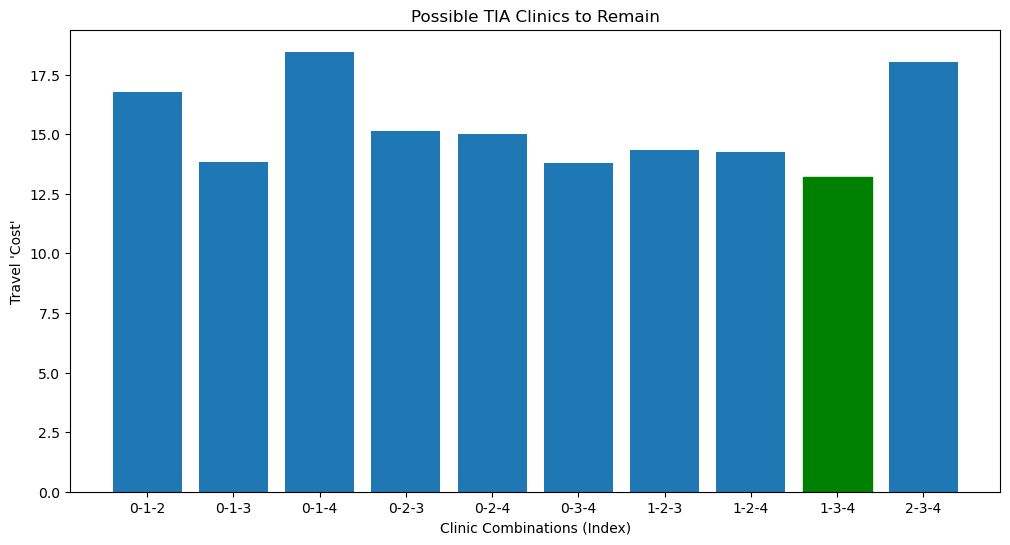

In [18]:
# your code goes here ...

# Create axis on which to generate the chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# convert solutions to strings
xlabels = []
for solution in comb:
    label = '-'.join(str(a) for a in solution)
    xlabels.append(label)

barlist = ax.bar(xlabels, results)
barlist[optimal_index].set_color('green')

# Title
ax.set_title("Possible TIA Clinics to Remain")

# X-axis label
ax.set_xlabel("Clinic Combinations (Index)")

# Y-axis label
ax.set_ylabel("Travel 'Cost'")

The end.